# Sources

Really Rough - API Not Set Up & not much QAQC...

*Using 2019 ACS 5 Year* Census Tracts

Highly recommend IPUMS! 

https://data2.nhgis.org/main

In [1]:
# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects
import requests

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

from pprint import pprint # Pretty Printing
import matplotlib.pyplot as plt # Basic Plotting
import contextily # Base Map Visualization
import warnings

warnings.filterwarnings('ignore') # Ignores some warnings

In [2]:
### Definitions

datapath = os.path.join('..', '..', 'Data')

mpls_tracts = gpd.read_file(os.path.join(datapath, 'mpls_tracts.geojson'))

In [3]:
# So I got these two tables from Census Bureau...

In [4]:
# Age & Sex & Demographics

foldername1 = 'ACSDP5Y2019.DP05_2023-07-06T002051'
dataname1 = 'ACSDP5Y2019.DP05-Data.csv'

full_df1 = pd.read_csv(os.path.join(datapath, foldername1, dataname1))

# We will get percentages for each tract
# First to get the denominator

# Are the total populations the same for RACE and HISPANIC tables??

total_pops = full_df1['DP05_0033E']
alt_pops = full_df1['DP05_0070E']

full_df1[total_pops != alt_pops]

,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0001MA,DP05_0001EA,DP05_0002E,DP05_0002EA,DP05_0002M,DP05_0002MA,...,DP05_0087PMA,DP05_0088PE,DP05_0088PM,DP05_0088PMA,DP05_0088PEA,DP05_0089PE,DP05_0089PEA,DP05_0089PM,DP05_0089PMA,Unnamed: 714
0,Geography,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Annotation of Margin of Error!!SEX AND AGE!!To...,Annotation of Estimate!!SEX AND AGE!!Total pop...,Estimate!!SEX AND AGE!!Total population!!Male,Annotation of Estimate!!SEX AND AGE!!Total pop...,Margin of Error!!SEX AND AGE!!Total population...,Annotation of Margin of Error!!SEX AND AGE!!To...,...,Annotation of Percent Margin of Error!!CITIZEN...,"Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...",Annotation of Percent Margin of Error!!CITIZEN...,"Annotation of Percent!!CITIZEN, VOTING AGE POP...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Annotation of Percent!!CITIZEN, VOTING AGE POP...","Percent Margin of Error!!CITIZEN, VOTING AGE P...",Annotation of Percent Margin of Error!!CITIZEN...,NaN


In [5]:
# Yes! Okay, whew.
# Select relevant columns (Just going for race right now)

focus_cols = ['GEO_ID', 'DP05_0033E',
             'DP05_0037E', 'DP05_0038E',
             'DP05_0039E', 'DP05_0044E',
             'DP05_0058E', 'DP05_0071E'] # + ['DP05_00' + str(column_index) + 'E' for column_index in range(37,72]

focus_df1 = full_df1[focus_cols]

description_dict = dict(zip(focus_df1.columns, focus_df1.loc[0,:]))

description_dict

{'GEO_ID': 'Geography',
 'DP05_0033E': 'Estimate!!RACE!!Total population',
 'DP05_0037E': 'Estimate!!RACE!!Total population!!One race!!White',
 'DP05_0038E': 'Estimate!!RACE!!Total population!!One race!!Black or African American',
 'DP05_0039E': 'Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native',
 'DP05_0044E': 'Estimate!!RACE!!Total population!!One race!!Asian',
 'DP05_0058E': 'Estimate!!RACE!!Total population!!Two or more races',
 'DP05_0071E': 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)'}

In [6]:
# Let's get percentages

new_col_names = ['GEO_ID', 'Total Population']

df1 = focus_df1.loc[1:,:].copy() # Skip the first line - just column descritions

df1['Total Population'] = df1.DP05_0033E.astype(int)

for old_col in focus_cols[2:]:

    new_col_name = 'Percent ' + description_dict[old_col].split('!!')[-1]

    new_col_names += [new_col_name]
    
    df1[new_col_name] = df1[old_col].astype(int)/df1['Total Population']*100

In [7]:
df1[new_col_names].head()

,GEO_ID,Total Population,Percent White,Percent Black or African American,Percent American Indian and Alaska Native,Percent Asian,Percent Two or more races,Percent Hispanic or Latino (of any race)
1,1400000US27053000101,3278,33.923124,34.167175,1.616840,18.639414,5.948749,7.504576
2,1400000US27053000102,5332,42.816954,31.826707,0.225056,12.453113,11.177794,8.439610
3,1400000US27053000300,3204,78.464419,15.043695,0.218477,0.000000,5.961298,2.528090
4,1400000US27053000601,5134,78.398909,13.030775,0.194780,1.733541,5.960265,3.837164
5,1400000US27053000603,2854,91.450596,1.296426,0.981079,1.191310,1.296426,7.463210


In [8]:
df1 = df1[new_col_names].copy()

In [9]:
# Income

foldername1 = 'ACSST5Y2019.S1903_2023-07-06T002226'
dataname1 = 'ACSST5Y2019.S1903-Data.csv'

full_df2 = pd.read_csv(os.path.join(datapath, foldername1, dataname1))

# Select relevant columns (Just going for median income right now)

focus_cols = ['GEO_ID', 'S1903_C03_001E', 'S1903_C01_001E']

focus_df2 = full_df2[focus_cols]

description_dict = dict(zip(focus_df2.columns, focus_df2.loc[0,:]))

description_dict

{'GEO_ID': 'Geography',
 'S1903_C03_001E': 'Estimate!!Median income (dollars)!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households',
 'S1903_C01_001E': 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households'}

In [10]:
df2 = focus_df2.loc[1:,:].copy()

df2['Median Income'] = df2.S1903_C03_001E.replace('250,000+', '250000').astype(int)

df2 = df2[['GEO_ID', 'Median Income']].copy()

In [11]:
# Merge the datasets

full_data = pd.merge(left=df1, right=df2, left_on='GEO_ID', right_on='GEO_ID')

In [12]:
# Merge with the census tracts

mpls_tracts['GEO_ID'] = mpls_tracts.GEOID.apply(lambda x: '1400000US' + x)

In [13]:
tracts_with_data = pd.merge(left=mpls_tracts, right=full_data, left_on='GEO_ID', right_on='GEO_ID')

In [14]:
tracts_with_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 22 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   STATEFP                                    116 non-null    object  
 1   COUNTYFP                                   116 non-null    object  
 2   TRACTCE                                    116 non-null    object  
 3   GEOID                                      116 non-null    object  
 4   NAME                                       116 non-null    object  
 5   NAMELSAD                                   116 non-null    object  
 6   MTFCC                                      116 non-null    object  
 7   FUNCSTAT                                   116 non-null    object  
 8   ALAND                                      116 non-null    int64   
 9   AWATER                                     116 non-null    int64   
 10  INTPTL

Percent White


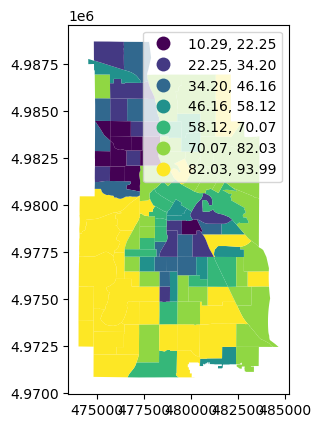

Percent Black or African American


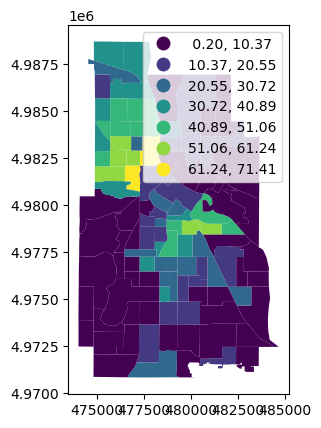

Percent American Indian and Alaska Native


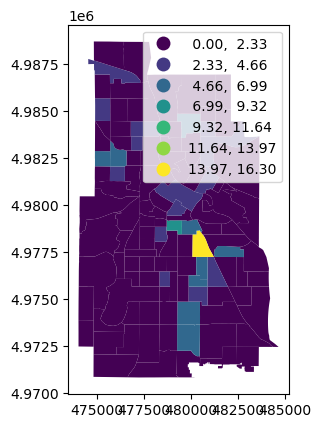

Percent Asian


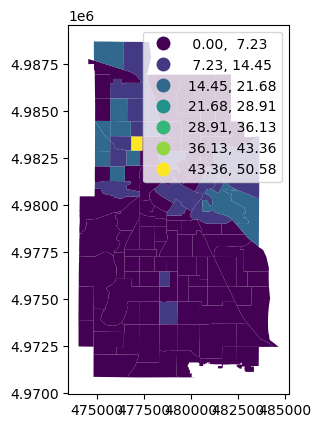

Percent Two or more races


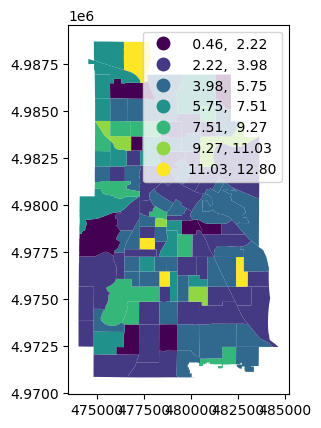

Percent Hispanic or Latino (of any race)


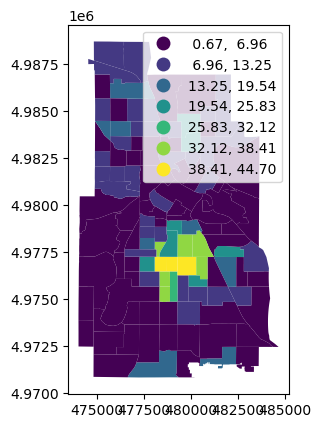

Median Income


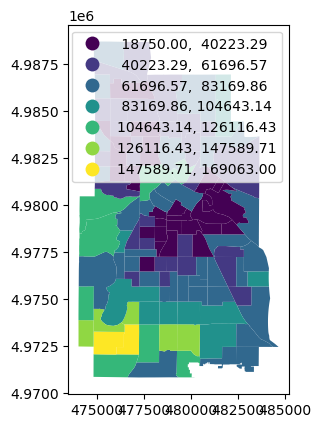

In [15]:
save_col_names = ['GEOID']

for col_index in range(15,22):

    col_name = tracts_with_data.columns[col_index]

    save_col_names += [col_name]
    
    print(col_name)
    
    tracts_with_data.plot(column = col_name, 
                          scheme = 'EqualInterval',
                          k=7,
                          legend = True)
    plt.show()

In [16]:
# Time to save

# Looks good, let's save

cols = save_col_names + ['geometry']

tracts_with_data[cols].to_file(os.path.join(datapath, 'mpls_demographics2019.geojson'))